In [156]:
import logging, sys
logging.disable(sys.maxsize)

import tqdm
# Let's do a selection based on a pure monte-carlo over all time where observing might occure. 
# Let's see if this converges quickly enough.
import astropy.time
from urllib.error import HTTPError
from gworacle import query, range as qrange, psd
from astropy.utils.data import download_file
import numpy


tstart = 1368975618
tend =   1434392434 # June 19th

ranges = []
psds = []
for t in tqdm.tqdm(range(tstart, tend, 86400)):
    try:
        fname = download_file(query.get_gwosc_inspiral_range_url(t), cache=True)
        d = qrange.extract_range_data_from_file(fname)
        fname = download_file(query.get_gwosc_spectrum_url(t), cache=True)
        p = psd.extract_psd_from_image(fname, target_f_min=10, target_f_max=4000, delta_f=1.0/8)
    except (TypeError, HTTPError, ValueError) as e:
        print(e)
        continue

    ranges.append(d)
    psds.append(p)

import pickle

pickle.dump(ranges, open('./o4_ranges.pkl', 'wb'))
pickle.dump(psds, open('./o4_psds.pkl', 'wb'))

 16%|█████████████████                                                                                           | 120/758 [01:23<06:30,  1.63it/s]

HTTP Error 404: Not Found


 43%|██████████████████████████████████████████████▍                                                             | 326/758 [03:40<04:03,  1.77it/s]

HTTP Error 404: Not Found


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 731/758 [08:28<00:11,  2.35it/s]

Malformed URL: 'None'
Malformed URL: 'None'


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 733/758 [08:29<00:07,  3.26it/s]

Malformed URL: 'None'
Malformed URL: 'None'


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 735/758 [08:30<00:09,  2.36it/s]

HTTP Error 404: Not Found


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 736/758 [08:30<00:09,  2.33it/s]

HTTP Error 404: Not Found


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 737/758 [08:31<00:09,  2.31it/s]

HTTP Error 404: Not Found


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 738/758 [08:31<00:08,  2.29it/s]

HTTP Error 404: Not Found


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 739/758 [08:31<00:08,  2.28it/s]

HTTP Error 404: Not Found


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 740/758 [08:32<00:07,  2.28it/s]

HTTP Error 404: Not Found


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [08:44<00:00,  1.44it/s]


In [360]:
import logging, sys
logging.disable(sys.maxsize)

# Let's do a selection based on a pure monte-carlo over all time where observing might occure. 
# Let's see if this converges quickly enough.
import astropy.time
from pycbc.distributions import Uniform, UniformSky, SinAngle, UniformAngle
from pycbc.detector import Detector
from urllib.error import HTTPError
from gworacle import query, range as qrange, psd
from astropy.utils.data import download_file
from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift
import numpy
import pickle
import tqdm

o4_psds = pickle.load(open('./o4_psds.pkl', 'rb'))
o4_ranges = pickle.load(open('./o4_ranges.pkl', 'rb'))

hp_ref, _ = get_fd_waveform(approximant="TaylorF2", mass1=1.4, mass2=1.4, f_lower=20, delta_f=1.0/8)

hps = {}
masses = numpy.geomspace(1, 500, 80)
srcmasses = numpy.geomspace(1, 500, 80)

for m in masses:
    hps[m], _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m, mass2=m, f_lower=20, delta_f=1.0/8)

vt_det = 0
vt_src = 0

size = int(1e3)

mdetmat = numpy.resize(masses, size * len(masses)).reshape(size, len(masses))

sky = UniformSky().rvs(size=size)
inc = SinAngle(inclination=None).rvs(size=size)['inclination']
pol = UniformAngle(polarization=None).rvs(size=size)['polarization']

relsnr = {}
for ifo in ['H1', 'L1', 'V1']:
    det = Detector(ifo)
    fp, fc = det.antenna_pattern(sky['ra'], sky['dec'], pol, 1000000000)
    ic = numpy.cos(inc)
    ip = 0.5 * (1.0 + ic * ic)
    relsnr[ifo] = ((ip * fp) ** 2.0 + (ic * fc) ** 2.0) ** 0.5 # Relative SNR


def get_vt(x):
    d, psds = x
    vt_src_part = numpy.zeros(len(srcmasses))
    vt_det_part = numpy.zeros(len(masses))
    try:
        if psds is None:
            return vt_src_part, vt_det_part
        
        sig_ref = {k: sigma(hp_ref, psds[k], low_frequency_cutoff=20, high_frequency_cutoff=1000) for k in psds}
        ifos_all = [k for k in psds if numpy.isfinite(sig_ref[k])]

        #for m in masses:
        #    sig[m] = {k: sigma(hps[m], psds[k], low_frequency_cutoff=20, high_frequency_cutoff=1000) for k in psds}
        
        for k in psds:
            sig[k] = numpy.array([sigma(hps[m], psds[k], low_frequency_cutoff=20, high_frequency_cutoff=1000) for m in masses])
        
        dt = 0.025
        nthresh = 10.0
        thours = numpy.arange(0, 24, dt)

        for thour in thours:
            ifos = []
            ranges = []
            
            for ifo in ifos_all:
                rtimes = d[ifo][0]
                rrange = d[ifo][1]
                if rtimes.min() > 24:
                    continue
                
                if abs(rtimes - thour).min() < dt * 1.1: # consider this online
                    ifos.append(ifo)
                    ranges.append(rrange[abs(rtimes - thour).argmin()])
       
            nsnrsq = 0
            for ifo, ran in zip(ifos, ranges): 
                hdist = ran * 8 * 2.26 # horizon at SNR 1

                # Calculate all the orietnation and det-mass combinations at once
                nsnrsq += (numpy.outer(relsnr[ifo], sig[ifo]) *  hdist / sig_ref[ifo]) ** 2.0 # SNR at fiducial distance
                    # Fiducial is 1Mpc, that way it can also be intereprted as the distance that gives you SNR 1. 

            if len(ifos) > 0:
                nsnr = nsnrsq ** 0.5
                dsamp = (nsnr / nthresh) # Distance at SNR threshold for sample
                z = redshift(dsamp) # Redshift limit at each sample
                msrc = mdetmat / (1 + z)  # Source frame mass each sample corresponds to 
                
                vt_samp = 4/3 * numpy.pi * dsamp**3.0 / size * dt # The per sample VT
                vt_det_part += vt_samp.sum(axis=0) # detector-frame vt

                # Simple linear interpolation

                for i in range(size):
                    vt_src_part += numpy.interp(srcmasses, msrc[i, :], vt_samp[i, :])
        #print(vt_det_part[4]  / 24 / 365.25 / 1000, vt_src_part[4]  / 24 / 365.25 / 1000)
    
    except (TypeError, HTTPError, ValueError) as e:
        print(e)
        pass
    return vt_src_part, vt_det_part

#vtps = list(map(get_vt, zip(o4_ranges, o4_psds)))

from multiprocessing import pool

with pool.Pool(16) as m:
    vtps = list(tqdm.tqdm(m.imap(get_vt, zip(o4_ranges, o4_psds)), total=len(o4_psds)))


for vtp in vtps:
    if vtp is not None:
        vt_src += vtp[0]
        vt_det += vtp[1]
    
    print(vt_det[4]  / 24 / 365.25 / 1000, vt_src[4]  / 24 / 365.25 / 1000)

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 536/746 [07:58<03:31,  1.01s/it]

'NoneType' object is not subscriptable


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [10:32<00:00,  1.18it/s]

6.6597694193053565 7.2566615624119875
18.077757239861135 19.66674033331694
31.80151710378546 34.60845474086824
59.09552847214629 64.827489276057
86.41976431174417 95.10910338911216
104.10073574366612 114.45741966283641
122.37947587745614 134.67593239079218
142.74175036916077 157.15627945173588
168.03559308582433 185.13357784560594
191.04100877140328 210.56645417962176
216.2564010470264 238.6181686758
241.88498322640476 267.0282859436997
267.5238539790812 295.41802212011885
288.4403353108571 318.6468804322805
318.7668478710514 352.37024822414827
340.5078836146099 376.38940622907415
374.1783357648727 413.94116316475174
407.55950193191944 451.13504537569384
437.27463917714994 484.189975510309
465.415701725686 515.4049202512364
487.13793278746283 539.5075160513563
509.76418953292944 564.5850515828347
530.7384658514225 587.8170162644644
552.3689902454671 611.8137639626704
576.8615331072847 638.9895587376459
599.6947876587273 664.3481165571337
621.3623639558039 688.3368445777412
637.50779828

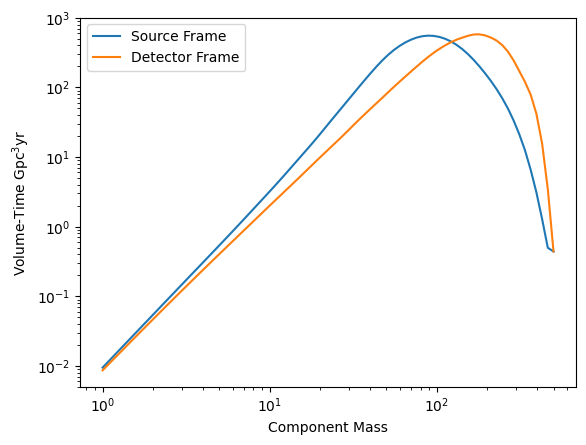

In [365]:
# Fixed Samples over sky / orientation
# For a given time -> a single detection limiting SNR for a given detect-frame mass
# that limit gives the limit for the corresponding source-frame mass. 
# If you sample over a wide range of detector-frame you can cover all source-frames
# each source-frame is the same integral, but switches to the corresponding 
# detect-frame that its limitting SNR corresponds tof

from matplotlib import pyplot as plt

plt.figure()
plt.plot(srcmasses, vt_src / 24 / 365.25 / 1e9, label="Source Frame")
plt.plot(masses, vt_det / 24 / 365.25 / 1e9, label="Detector Frame")
plt.xlabel('Component Mass')
plt.ylabel("Volume-Time Gpc$^3$yr")
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [364]:
1 / numpy.interp(1.4, srcmasses, vt_src / 24 / 365.25 / 1e9)

45.14697551898563

In [363]:
import h5py
with h5py.File('./vt_chirp_10.hdf', 'w') as f:
    f['srcmasses'] = srcmasses
    f['masses'] = masses
    f['vt_src'] = vt_src / 24 / 365.25 / 1e9
    f['vt_det'] = vt_det / 24 / 365.25 / 1e9

In [ ]:
@